# Time series forecasting with GluonTS

The GluonTS toolkit contains components and tools for building time series models using MXNet. The models that are currently included are forecasting models but the components also support other time series use cases, such as classification or anomly detection. 

The toolkit is not intended as a forecasting solution for businesses or end users but it rather targets scientists and engineers who want to tweak algorithms or build and experiment with their own models.  

GluonTS contains:
- Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
- Data loading and processing
- A number of pre-built models
- Plotting and evaluation facilities
- Artificial and real datasets (only external datasets with blessed license)

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

## Loading datasets

GluonTS comes with a number of publicly available datasets. 

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


An available dataset can be easily downloaded by its name. If the dataset already exists locally it is not downloaded again by setting `regenerate=False`.

In [4]:
dataset = get_dataset("m4_hourly", regenerate=False)

INFO:root:using dataset already processed in path m4_hourly.


### What is in a dataset?

In general, the datasets provided by GluonTS are objects that consists of three main components:
- `dataset.train` is an iterable collection of data entries used for training.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` containts metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc. 

Of course a custom dataset does not need to have this specific format but it should be iterable and it should have a "target" and a "start" field.

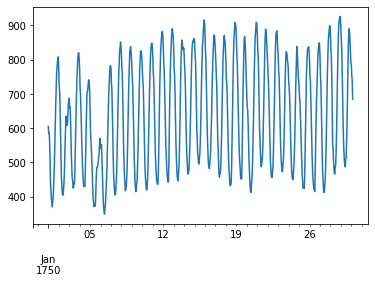

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.show()

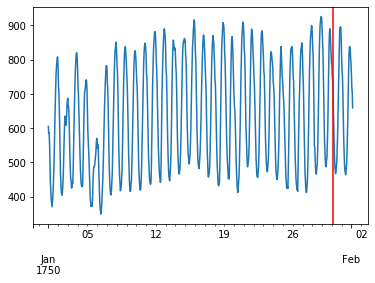

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.show()

In [7]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.time_granularity}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## Training an existing model (`Estimator`)

As we already mentioned, GluonTS comes with a number of pre-built models that can be used directly with minor hyperparameter configurations. For starters we will use one of these predefined models to go through the whole pipeline of training a model, predicting, and evaluating the results. 

GluonTS gives focus (but is not restricted) to probabilistic forecasting, i.e., forecasting the future distribution of the values and not the future values themselves (point estimates) of a time series. Having estimated the future distribution of each time step in the forecasting horizon, we can draw a sample from the distribution at each time step and thus create a "sample path", that can be seen as a possible realization of the future. In practice we draw multiple samples and create multiple sample paths which can be used for visualization, evalution of the model, to derive statistics, etc.

In this example we will use a simple pre-built feedforward neural network estimator that takes as input a window of length `context_length` and predicts the distribution of the values of the subsequent future window of length `prediction_length`. 

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g. the `prediction_length`) or specific for the particular estimator (e.g. number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained. i.e., the number of epochs, the learning rate, etc.  

In [8]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

In [9]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.time_granularity,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=200,),
)

After specifing our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` just by invoking the `.train` method of the estimator. The training returns a predictor that can be used to predict.

In [10]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 483
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 174.06it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[0] Elapsed time 1.151 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.064833
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 164.55it/s, avg_epoch_loss=4.71]
INFO:root:Epoch[1] Elapsed time 1.217 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.705897
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 175.93it/s, avg_epoch_loss=4.53]
INFO:root:Epoch[2] Elapsed time 1.139 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.533855
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 183.31it/s, avg_epoch_loss=4.54]
INFO:root:Epoch[3] Elapsed time 1.092 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.536518
INFO:root:Epoch[4] Le

Now we have a predictor in our hands. We can use it to predict the last window of the `dataset.test` and evaluate how our model performs.

GluonTS comes with the `make_evaluation_predictions` function that automates all this procedure. Roughly, this module performs the following steps:
- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining dataset to predict (in the form of sample paths) the "future" window that was just removed 
- The module outputs a generator over the forecasted sample paths and a generator over the `dataset.test` 

In [11]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [12]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths
)

In [13]:
print(type(forecast_it))
print(type(ts_it))

<class 'generator'>
<class 'generator'>


First, we can convert these generators to lists to ease the subsequent computations.

In [14]:
forecasts = list(forecast_it)
tss = list(ts_it)

Now, let's see what do these lists contain under the hood. Let's start with the time series `tss` that is simpler. Each item in the `tss` list is just a pandas dataframe that contains the actual time series.

In [15]:
print(type(tss[0]))

<class 'pandas.core.frame.DataFrame'>


In [16]:
k = 3
tss[0].head(k)  # show the k first values

,0
1750-01-01 00:00:00,605.0
1750-01-01 01:00:00,586.0
1750-01-01 02:00:00,586.0


The `forecasts` list is a bit more complex. Each item in the `forecasts` list is an object that contains all the sample paths, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [17]:
print(type(forecasts[0]))

<class 'gluonts.model.forecast.SampleForecast'>


In [18]:
print(f"Number of sample paths: {forecasts[0].num_samples}")
print(f"Start date of the forecast window: {forecasts[0].start_date}")
print(f"Frequency of the time series: {forecasts[0].freq}")

Number of sample paths: 100
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


Apart from retrieving basic information we can do some more complex calculation such as to compute the mean or a given quantile of the values of the forecasted window.

In [19]:
print(f"Mean of the future window:\n {forecasts[0].mean}")
print(f"0.5-quantile (median) of the future window:\n {forecasts[0].quantile(0.5)}")

Mean of the future window:
 [630.14233 613.2987  562.47034 509.24152 526.2424  456.79422 464.68567
 434.9127  460.78812 540.06934 576.9978  617.4263  712.99005 797.1186
 837.1842  839.78235 832.2667  845.46454 870.83264 859.3618  805.627
 793.0982  767.45306 739.8069  640.1241  607.54584 570.72205 549.9565
 506.41013 485.43344 494.72223 533.6078  542.5674  567.8772  602.8741
 726.63556 708.6857  850.218   849.72174 770.77576 860.7844  846.8274
 878.09686 844.58655 834.2047  792.45703 747.78094 757.1613 ]
0.5-quantile (median) of the future window:
 [620.7824  611.6946  553.83856 504.80392 525.68286 461.94034 473.4364
 451.47128 501.2785  543.06226 588.233   617.11566 720.4439  781.28204
 835.1848  830.32184 847.6181  868.1459  846.6592  853.9764  814.9823
 787.19794 756.68097 728.9227  622.317   592.6674  563.01935 550.6772
 522.9531  484.84055 493.89993 540.7561  539.8684  570.6127  595.18884
 713.81    714.0525  807.886   843.65216 811.47656 875.1572  852.12445
 878.942   839.5823  8

Finally, each forecast object has a `.plot` method that can be parametrized to show the mean, prediction intervals, etc.

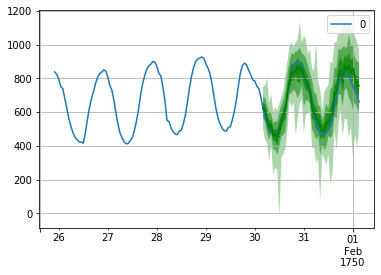

In [20]:
plot_length = 150 
tss[0][-plot_length:].plot()  # plot the time series
forecasts[0].plot(prediction_intervals=(50.0, 80.0, 95.0), # confidence intervals (plotted in different shades)
              show_mean=True,
              color='g')
plt.grid()
plt.show()

We can also evaluate the quality of our forecasts. The `Evaluator` returns aggregate error metrics as well as metric per time series which can be used e.g. for scatter plots.

In [21]:
from gluonts.evaluation import Evaluator

In [22]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:01<00:00, 221.33it/s]


In [23]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 7553983.0613646945,
    "abs_error": 8948334.836429596,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 3.009074433782214,
    "sMAPE": 0.17490047617392576,
    "MSIS": 34.701764834178704,
    "QuantileLoss[0.1]": 4656526.581197263,
    "Coverage[0.1]": 0.103311191626409,
    "QuantileLoss[0.5]": 8948334.813533306,
    "Coverage[0.5]": 0.5190217391304348,
    "QuantileLoss[0.9]": 6556099.088259315,
    "Coverage[0.9]": 0.8831018518518519,
    "RMSE": 2748.451029464541,
    "NRMSE": 0.37522427358155,
    "ND": 0.06147571240349811,
    "wQuantileLoss[0.1]": 0.031990676940196715,
    "wQuantileLoss[0.5]": 0.06147571224619893,
    "wQuantileLoss[0.9]": 0.04504087848812327,
    "mean_wQuantileLoss": 0.04616908922483964,
    "MAE_Coverage": 0.013077026301663991
}


In [24]:
item_metrics.head(10)

,Coverage[0.1],Coverage[0.5],Coverage[0.9],MASE,MSE,MSIS,QuantileLoss[0.1],QuantileLoss[0.5],QuantileLoss[0.9],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.000000,0.791667,1.000000,0.786284,2.011036e+03,5.422732,880.775061,1599.161041,1324.999951,1599.161133,659.250000,31644.0,NaN,0.050535,42.371302
1,0.250000,0.979167,1.000000,2.109795,1.376479e+05,12.684183,4047.677417,16720.512085,8088.447168,16720.511719,2586.437500,124149.0,NaN,0.131540,165.107988
2,0.000000,0.104167,0.770833,1.644269,2.571278e+04,9.254714,3350.344336,6226.311401,1597.340649,6226.311523,1354.791667,65030.0,NaN,0.091813,78.889053
3,0.020833,0.416667,0.979167,1.487107,2.293956e+05,8.017932,9273.137158,18486.440674,7389.413867,18486.441406,4912.145833,235783.0,NaN,0.076594,258.982249
4,0.062500,0.729167,1.000000,1.138499,8.357853e+04,6.270616,3965.149548,10956.588257,7201.456885,10956.587891,2731.000000,131088.0,NaN,0.075888,200.494083
5,0.000000,0.666667,1.000000,1.448877,1.512505e+05,11.162966,9757.192773,14804.681152,13055.524316,14804.681641,6320.395833,303379.0,NaN,0.049557,212.875740
6,0.000000,0.437500,1.000000,0.702103,3.138920e+06,7.254496,68446.798437,65638.945312,67196.346875,65638.945312,41360.937500,1985325.0,NaN,0.034372,1947.687870
7,0.000000,0.416667,0.979167,0.912632,3.721858e+06,7.587852,55893.839453,71143.445312,52368.667578,71143.445312,32098.041667,1540706.0,NaN,0.045908,1624.044379
8,0.000000,0.791667,1.000000,1.147173,7.083603e+06,6.471173,42371.522266,101923.373047,72617.897266,101923.375000,34184.583333,1640860.0,NaN,0.061069,1850.988166
9,0.000000,0.291667,1.000000,1.407518,4.328754e+02,14.767098,827.039917,711.187958,665.258356,711.187988,446.000000,21408.0,NaN,0.033593,10.526627


[]

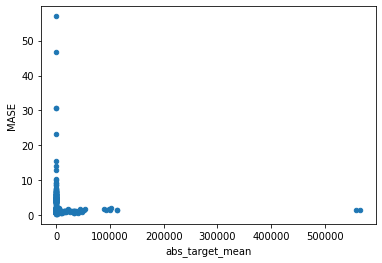

In [25]:
item_metrics.plot(x='abs_target_mean', y='MASE', kind='scatter')
plt.plot()

## Create your own forecast model

For creating your own forecast model you need to:
- define the training and prediction network
- define a new estimator that specifies any data processing and uses the networks

The training and prediction networks can be arbitrarily complex but they should follow some basic rules:
- Both should have a `hybrid_forward` method that defines what should happeni when the network is called    
- The trainng network's `hybrid_forward` should return a **loss** based on the prediction and the true values
- The prediction network's `hybrid_forward` should return the predictions 

For example, we can create a simple training network that defines a neural network with output dimension equal to `prediction_length` and uses the L1 loss in the `hybrid_forward` method, and a prediction network that is (and should be) identical to the training network (by inheriting the class).

In [26]:
class MyTrainNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
    
        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

Now, we need to construct the estimator which should also follow some rules:
- It should include a `create_transformation` method that defines all the possible feature transformations and how the data is split during training
- It should include a `create_training_network` method that returns the training network configured with any necessary hyperparameters
- It should include a `create_predictor` method that creates the prediction network, and returns a `Predictor` object 

A `Predictor` defines the `predictor.predict` method of a given predictor. This method takes the test dataset, it passes it through the prediction network to take the predictions, and yields the predictions. You can think of the `Predictor` object as a wrapper of the prediction network that defines its `predict` method. 

Earlier, we used the `make_evaluation_predictions` to evaluate our predictor. Internally, the `make_evaluation_predictions` function invokes the `predict` method of the predictor to get the forecasts.

In [27]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter, FieldName
from mxnet.gluon import HybridBlock

In [28]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.freq = freq
        
    
    def create_transformation(self):
        # Feature transformation that the model uses for input. 
        # Here we use a transformation that randomly select training samples from all time series.
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )
    
    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

Now, we can repeat the same pipeline as in the case we had a pre-built model: train the predictor, create the forecasts and evaluate the results.

In [29]:
estimator = MyEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=200,
    freq=dataset.metadata.time_granularity,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=200,),
)

In [30]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in MyTrainNetwork: 128
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 197.44it/s, avg_epoch_loss=2.03e+03]
INFO:root:Epoch[0] Elapsed time 1.014 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2029.359129
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 195.89it/s, avg_epoch_loss=849]
INFO:root:Epoch[1] Elapsed time 1.022 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=849.390379
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 195.24it/s, avg_epoch_loss=612]
INFO:root:Epoch[2] Elapsed time 1.026 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=612.330535
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 196.24it/s, avg_epoch_loss=590]
INFO:root:Epoch[3] Elapsed time 1.020 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=590.001082
INFO:root:Epoch[4] Learning r

In [31]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor, 
    num_eval_samples=100
)

In [32]:
forecasts = list(forecast_it)
tss = list(ts_it)

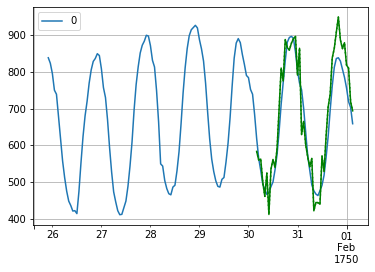

In [33]:
plot_length = 150 
tss[0][-plot_length:].plot()  # plot the time series
forecasts[0].plot(prediction_intervals=(50.0, 80.0, 95.0), # confidence intervals (plotted in different shades)
              show_mean=True,
              color='g')
plt.grid()
plt.show()

We observe from the plot above that we cannot actually see any confidence interval in the predictions. This is expected since the networks that we defined do not do probabilistic forecasting but they just give point estimates. That is, the prediction netwrok does not return samples from a learned distribution. Rather, for a fixed input the network gives always the same output. So, by requiring 100 sample paths in such a network, we get 100 times the same output.

In [34]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:01<00:00, 238.77it/s]


In [35]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 12355396.748027263,
    "abs_error": 11666035.696647644,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 5.321710939891199,
    "sMAPE": 0.2200588770364635,
    "MSIS": 212.86843865661888,
    "QuantileLoss[0.1]": 15668591.68317585,
    "Coverage[0.1]": 0.5287842190016103,
    "QuantileLoss[0.5]": 11666035.76894474,
    "Coverage[0.5]": 0.5287842190016103,
    "QuantileLoss[0.9]": 7663479.854713631,
    "Coverage[0.9]": 0.5287842190016103,
    "RMSE": 3515.0244306444392,
    "NRMSE": 0.47987847499211816,
    "ND": 0.08014651535572273,
    "wQuantileLoss[0.1]": 0.1076443666548239,
    "wQuantileLoss[0.5]": 0.08014651585240906,
    "wQuantileLoss[0.9]": 0.05264866504999423,
    "mean_wQuantileLoss": 0.08014651585240906,
    "MAE_Coverage": 0.27626140633387014
}


In [36]:
item_metrics.head(10)

,Coverage[0.1],Coverage[0.5],Coverage[0.9],MASE,MSE,MSIS,QuantileLoss[0.1],QuantileLoss[0.5],QuantileLoss[0.9],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.645833,0.645833,0.645833,1.070580,3.023796e+03,42.823197,3078.279968,2177.369568,1276.459167,2177.369629,659.250000,31644.0,NaN,0.068318,42.371302
1,0.937500,0.937500,0.937500,2.519738,2.253290e+05,100.789544,35595.396069,19969.389526,4343.382983,19969.388672,2586.437500,124149.0,NaN,0.146134,165.107988
2,0.208333,0.208333,0.208333,1.796990,3.433879e+04,71.879626,2371.432129,6804.618164,11237.804199,6804.618164,1354.791667,65030.0,NaN,0.104477,78.889053
3,0.645833,0.645833,0.645833,1.300016,1.922514e+05,52.000633,21345.826074,16160.688965,10975.551855,16160.688477,4912.145833,235783.0,NaN,0.067779,258.982249
4,0.458333,0.458333,0.458333,1.368561,1.182457e+05,54.742459,12375.229004,13170.646973,13966.064941,13170.646484,2731.000000,131088.0,NaN,0.102629,200.494083
5,0.458333,0.458333,0.458333,1.643012,1.742737e+05,65.720461,13343.587402,16788.351074,20233.114746,16788.351562,6320.395833,303379.0,NaN,0.057128,212.875740
6,0.458333,0.458333,0.458333,1.072656,7.375931e+06,42.906243,75022.235156,100281.566406,125540.897656,100281.562500,41360.937500,1985325.0,NaN,0.052648,1947.687870
7,0.395833,0.395833,0.395833,1.438735,8.463039e+06,57.549414,87810.589844,112155.355469,136500.121094,112155.359375,32098.041667,1540706.0,NaN,0.077896,1624.044379
8,0.791667,0.791667,0.791667,1.906009,1.791851e+07,76.240347,288626.262500,169343.968750,50061.675000,169343.968750,34184.583333,1640860.0,NaN,0.092424,1850.988166
9,0.500000,0.500000,0.500000,2.724764,1.115769e+03,108.990566,1225.087854,1376.763733,1528.439612,1376.763672,446.000000,21408.0,NaN,0.064794,10.526627


[]

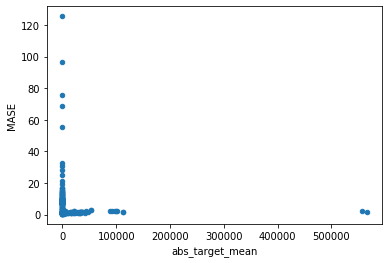

In [37]:
item_metrics.plot(x='abs_target_mean', y='MASE', kind='scatter')
plt.plot()